In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

noise_models = []

for i in range(5):
    #scaling probabilities 
    prob_1 = (i+1)*0.001
    prob_2 = (i+1)*0.01
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    noise_models.append(noise_model)


Running on a sample circuit

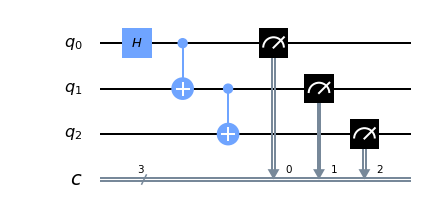

In [2]:

# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

circ.draw(output = 'mpl')

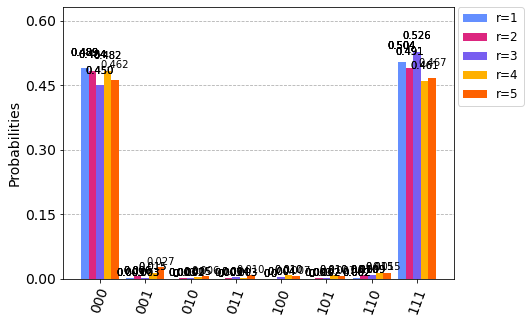

In [3]:
#running all results on a simulator
simulator = Aer.get_backend('qasm_simulator')

counts = []
for noise_model in noise_models:
    sim_result = execute(circ, backend=simulator, noise_model = noise_model, shots=1024).result()
    counts.append(sim_result.get_counts(circ))
plot_histogram([counts[0], counts[1], counts[2], counts[3], counts[4]], legend=['r=1', 'r=2','r=3','r=4','r=5' ])

# VQE with different noise scalings

In [4]:
# Set up VQE
#Doing away with all libraries
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries


from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram
    

In [18]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [19]:
#Begin VQE

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA

# Specifying whether running code on a simulator or an actual quantum device
backend = Aer.get_backend("qasm_simulator")
# creating a list of distances to run VQE on 
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
#adding empty boxes for later usage
for i in range(5): 
    vqe_energies.append([])

#Quantum Instances for each noise model 
quantum_instances = []
for noise_model in noise_models:
    quantum_instance = QuantumInstance(backend=backend, 
                                   noise_model=noise_model )
    quantum_instances.append(quantum_instance)

optimizer = COBYLA(maxiter=1000)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
    # Finding exact energies to show how off VQE was from exact energy curve
    result = ExactEigensolver(qubitOp).run()
    exact_energies.append(result['energy'] + shift)
    # Initial STate 
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        'parity'
    ) 
    print(qubitOp.num_qubits)
    # UCCSD Variational Form
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    # Running VQE using a simulator, not actual quantum computer
    vqe = VQE(qubitOp, var_form, optimizer)
    
    #running VQE for each noise scaling
    for i in range(5):
        results = vqe.run(quantum_instances[i])['energy'] + shift
        vqe_energies[i].append(results)
        print( str(i)+  " phase done")
    
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", results, "Exact Energy:", 
          exact_energies[-1])
print("All energies have been calculated")

HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
2
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
Interatomic Distance: 0.5 VQE Result: -0.78478045142368 Exact Energy: -1.0551597944706235
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbitals: 4
2
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
Interatomic Distance: 0.6 VQE Result: -0.8874476353563199 Exact Energy: -1.1162860068695386
HF energy: -1.8733164791617076
# of electrons: 2
# of spin orbitals: 4
2
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
Interatomic Distance: 0.7 VQE Result: -0.9445856189539313 Exact Energy: -1.1361894540659203
HF energy: -1.7723219111265944
# of electrons: 2
# of spin orbitals: 4
2
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
Interatomic Distance: 0.8 VQE Result: -0.96732278263427 Exact Energy: -1.1341476666770967
HF energy: -1.679888719820057
# of electrons: 2
# of spin orbitals: 4
2
0 phase done


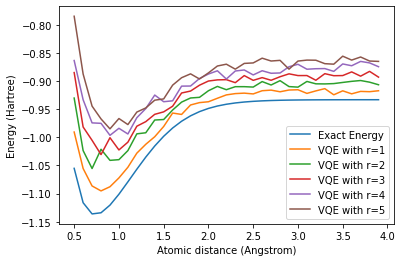

In [22]:
# plotting the data
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies[0], label="VQE with r=1")
plt.plot(distances, vqe_energies[1], label="VQE with r=2")
plt.plot(distances, vqe_energies[2], label="VQE with r=3")
plt.plot(distances, vqe_energies[3], label="VQE with r=4")
plt.plot(distances, vqe_energies[4], label="VQE with r=5")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

# Analysis 
The graph suggests that if we scale the depolarizing error higher and higher, our results tend to go away from the exact energy. So noise amplification diverges VQE estimate from actual answer. 

# To do next
Extrapolate

First Order

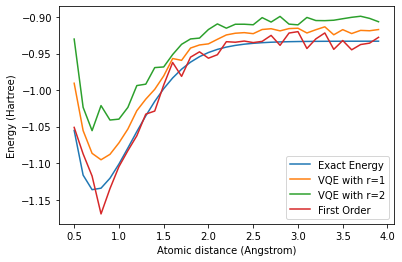

In [23]:
first_order =[]
#Extrapolating Math 
for i in range(len(vqe_energies[0])):
    f = vqe_energies[0][i] - ((vqe_energies[1][i])/2)
    f = 2*f
    first_order.append(f)
# plotting the data
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies[0], label="VQE with r=1")
plt.plot(distances, vqe_energies[1], label="VQE with r=2")
plt.plot(distances, first_order, label="First Order")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()
    

Second Order

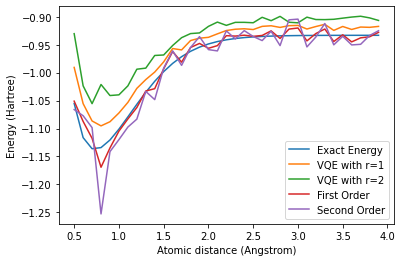

In [24]:
second_order = []
for i in range(len(vqe_energies[0])):
    t = ((3*vqe_energies[1][i])/2) - ((vqe_energies[2][i]))
    s = ((3*first_order[i])/2) - t
    second_order.append(s)
# plotting the data
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies[0], label="VQE with r=1")
plt.plot(distances, vqe_energies[1], label="VQE with r=2")
plt.plot(distances, first_order, label="First Order")
plt.plot(distances, second_order, label="Second Order")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()
    
